## Experiment: Use gemini with tool-calling to obtain information on funds

In [ ]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, pathlib

BASE = '..'
dirs = [
    f'{BASE}/data/raw',
    f'{BASE}/data/processed',
    f'{BASE}/reports/figures',
    f'{BASE}/src',
]
for d in dirs:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)
dirs

['/content/drive/MyDrive/Asset_Recommender/data/raw',
 '/content/drive/MyDrive/Asset_Recommender/data/processed',
 '/content/drive/MyDrive/Asset_Recommender/reports/figures',
 '/content/drive/MyDrive/Asset_Recommender/src']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import ast

import asyncio
import aiohttp

import os
from dotenv import load_dotenv

from google import genai
from google.genai import types

from pydantic import BaseModel, Field

from tavily import TavilyClient

from io import BytesIO
from PyPDF2 import PdfReader

from langchain_community.document_loaders import WebBaseLoader

import time

from bs4 import SoupStrainer

import requests

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [ ]:
from pathlib import Path
BASE = Path('..')
RAW_DIR = BASE / 'data/raw'
OUT_DIR = BASE / 'data/processed'
FIG_DIR = BASE / 'reports/figures'
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

### Read data and define API keys

In [5]:
asset_metadata = pd.read_csv(RAW_DIR / "asset_information.csv")
markets = pd.read_csv(RAW_DIR / "markets.csv")

In [ ]:
# add your own api keys in a .env file
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [ ]:
MODEL = 'gemini-2.5-flash-lite'
client = genai.Client(api_key=GEMINI_API_KEY)
tavily_client = TavilyClient(TAVILY_API_KEY)

# system prompt to use for gemini after using the data
SYSTEM_PROMPT = '''
# Identity

You are a financial analyst expert, capable of describing different financial assets in great detail
using your own knowledge and/or data from web search results.

# Task

Given a asset ISIN, name, its short name, asset category and information returned from a web search tool about the asset, you are to give a detailed and objective description of the financial asset.
Your response should be between 200 to 300 words. If you cannot reach this length, expand with additional details relevant to the asset.
The financial assets will only be of the following three types: Mutual Fund (MTF), Stock or Bond.

# Instructions

* First, identify the given asset type.
* If the asset type is a Mutual Fund, you should output:
  - The fund's objective(s)
  - The fund's investment style
* If the asset type is a Stock, you should output:
  - Information about the company
  - The underlying company's business
  - The type of stock (E.g. large-cap, mid-cap, small-cap, growth stocks, income stocks, value stocks, blue-chip stocks, etc.)
* If the asset type is a Bond, you should output:
  - The bond's objective(s)
  - Underlying company information for this bond
  - Underlying company business for this bond
  - The bond's maturity date
  - The bond's yield
* IMPORTANT: Refer to the information provided to you from the web search as much as possible. If all the web search results run into error, then you may use your own knowledge.
* The information given to you may be in another language. However, you must output English.
* Only reference information from reliable URLs. If the URL seems unreliable, or the content is opinionated, you may ignore it when creating your output.
* Do not speculate or fabricate missing information. Only describe what is you know about the asset.
* You can, and should add on to the asset description if you think it is informative to a user considering buying this asset.
* You are to output both the asset ticker, and description.
* You should not blindly output the Short Name as the ticker. Sometimes, the Short Name may be unknown. You can use your own knowledge to output ticker, but output "unknown" as the ticker if you do not know.

# Example Input and Output

Input: ISIN: US9229083632, Name: Vanguard S&P 500 ETF, Short Name: VOO, Asset Category: MTF

Output:

{
  "ticker": "VOO",
  "description": "# Objective\nThe investment seeks to track the performance of the Standard & Poor's 500 Index that measures the investment return of large-capitalization stocks. The fund employs an indexing investment approach designed to track the performance of the Standard & Poor's 500 Index, a widely recognized benchmark of U.S. stock market performance that is dominated by the stocks of large U.S. companies. The advisor attempts to replicate the target index by investing all, or substantially all, of its assets in the stocks that make up the index, holding each stock in approximately the same proportion as its weighting in the index. The fund is non-diversified.\n# Investment Style\ninvestment_style_here"
}
'''

### Define function for model to call

In [ ]:
# helper functions for getting content from the URLs
async def get_pdf_content(url: str, session: aiohttp.ClientSession) -> dict:
    """Extract text content from PDF URL"""
    try:
        async with session.get(url, timeout=15) as resp:
            resp.raise_for_status()
            content = await resp.read()

        reader = PdfReader(BytesIO(content))
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text + "\n"

        return {"content": text, "url": url}

    except Exception as e:
        print(f"Error processing PDF {url}: {e}")
        return {"content": "error", "url": url}


async def get_webpage_content(url: str) -> dict:
    """Extract text content from webpage URL"""
    try:
        def load_sync():
            loader = WebBaseLoader(
                url,
                bs_kwargs={
                    "parse_only": SoupStrainer(["h1", "h2", "h3", "p", "table"]),
                },
                requests_kwargs={
                    "headers": {
                        "User-Agent": (
                            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                            "AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/115.0.0.0 Safari/537.36"
                        ),
                        "Accept-Language": "en-US,en;q=0.9",
                    },
                    "timeout": 15,
                },
            )
            docs = loader.load()
            text = "\n".join(doc.page_content.strip("\n") for doc in docs)
            return {"content": text, "url": url}

        return await asyncio.to_thread(load_sync)

    except Exception as e:
        print(f"Error processing webpage {url}: {e}")
        return {"content": "error", "url": url}


async def parse_url_content(response: dict) -> list[dict]:
    """Parse URLs from a response and extract their content concurrently"""
    urls = [res["url"] for res in response["results"]]

    async with aiohttp.ClientSession() as session:
        tasks = []
        for url in urls:
            if url.lower().endswith(".pdf"):
                tasks.append(get_pdf_content(url, session))
            else:
                tasks.append(get_webpage_content(url))

        results = await asyncio.gather(*tasks, return_exceptions=True)

    # Process results and handle any exceptions
    parsed_content = []
    for result, url in zip(results, urls):
        if isinstance(result, Exception):
            print(f"Exception for {url}: {result}")
            parsed_content.append({"content": "error", "url": url})
        else:
            parsed_content.append(result)

    return parsed_content

def preprocess_search_content(parsed_content: list[dict]) -> str:
    res = ""
    i = 1
    for c in parsed_content:
        res = res + f"### Search result {i}\nurl: {c['url']}\n{c['content'][:30000]}\n" # limit to 30k characters for each
        i += 1
    return res

# define function for web search
def web_search(query: str) -> dict:
    '''
    Performs web search query. Returns the web page content of up to 5 urls from the web search result.
    The returned results are to be passed into the LLM as context.

    Args:
        query (str): Search query to look for.

    Returns:
        parsed_content (str): The results from the search query.
    '''
    # performs a search query on the data
    # consider adding " summary" behind
    response = tavily_client.search(
        query,
        max_results=5,
        sort_by="relevancy",
    )

    return response

# define structured output schema for model
class AssetMetadata(BaseModel):
    ticker: str = Field(default="unknown", description="Ticker of asset")
    description: str = Field(default="unknown", description="Description of asset")

# main function to call the web search function and llm to generate the analysis
def call_llm(isin: str, name: str, short_name: str, asset_category: str, parsed_content: list[dict]) -> list:
    # create chat history to return for debugging and evaluating purposes
    history = []

    # create the prompt and hardcode search query
    prompt = f'ISIN: {isin}, Name: {name}, Short Name: {short_name}, Asset Category: {asset_category}'

    search_results = preprocess_search_content(parsed_content)

    # convert it into a tool response
    function_response_part = types.Part.from_function_response(
        name="web_search",
        response={"result": search_results},
    )
    tool_content = types.Content(
        parts=[
            function_response_part,
        ],
        role='tool'
    )

    # create the user content for llm to respond to
    user_content = types.Content(
        parts=[
            types.Part(text=prompt),
        ],
        role='user',
    )

    history.append(user_content)
    history.append(tool_content)

    # generate response with function call result
    response: types.GenerateContentResponse = client.models.generate_content(
        model=MODEL,
        contents=history,
        config=types.GenerateContentConfig(
            system_instruction=[
                SYSTEM_PROMPT
            ],
            temperature=0.2,
            thinking_config=types.ThinkingConfig(
                thinking_budget=512
            ),
            max_output_tokens=1200,
            # for structured output
            response_mime_type='application/json',
            response_schema=AssetMetadata
        ),
    )

    history.append(response)

    return history

## Perform web search first, on all the 836 assets

In [ ]:
# NOTE: do not run this cell, we have already performed the web search
error_results = []
for idx, row in asset_metadata.iterrows():
    query = f'{row["ISIN"]} {row["assetName"]} information'
    success = False
    print(f"Index: {idx}, Asset: {row['assetName']}")
    for attempt in range(3):
        try:
            # write to filepath if successful
            response = web_search(query)
            filepath = f'../../data/tavily_results/{idx}.json'
            with open(filepath, "w") as f:
                json.dump(response, f, indent=2)
            success = True
            break # break out of inner for loop
        except requests.exceptions.HTTPError as e:
            if "429" in str(e):
                time.sleep(70) # sleep 70 seconds
                continue
    if not success:
        error_results.append(idx)

Index: 0, Asset: DHLOS PET OTE
Index: 1, Asset: DELOS FIXED INCOME PLUS - BOND FUND
Index: 2, Asset: ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ & ΜΕΣΟΠΡΟΘΕΣΜΩΝ ΕΠΕΝΔΥΣΕΩΝ-ΟΜ
Index: 3, Asset: DHLOS EISODHMATOS OMOLOGIAKO ESOTERIKOY
Index: 4, Asset: DHLOS EUROBOND
Index: 5, Asset: DELUBFB Delos USD Bond Fund
Index: 6, Asset: DELSBBF Delos Synthesis Best Blue - Bond Fund of F
Index: 7, Asset: DELOS USD-INTERNATIONAL BD
Index: 8, Asset: DHLOS MIKTO AMOIVAIO KEFALAIO
Index: 9, Asset: DHLOS STRATEGIC INVESTMENTS
Index: 10, Asset: DELOS UNION FUND-BALANCED FD
Index: 11, Asset: A/K  DHLOS SYNTHESIS BEST YELLOW FUNDS OF FUND ΜΙΚ
Index: 12, Asset: DHLOS BLUE CHIPS
Index: 13, Asset: DHLOS SMALL CAP
Index: 14, Asset: DHLOS SYNTHESIS BEST FUND OF FUNDS ΜΕΤΟΧΙΚΟ
Index: 15, Asset: N.P.INSURANCE ΝΕΟΣ ΠΟΣΕΙΔΩΝ ΜΙΚΤΟ
Index: 16, Asset: DELOS GREEK GROW-DOMEST BOND
Index: 17, Asset: DELOS EXTRA INCOME 5year-Bond Fund
Index: 18, Asset: iShares € Govt Bond 3-5yr UCITS ETF EUR (Dist) | IBGX
Index: 19, Asset: ASML Holding NV
Index

Now, we have all the links available for us to make requests to

In [ ]:
error_results

[]

In [ ]:
responses = []
# ensure sequential order of loading data
for i in range(836): # 836 assets so 836 indices
    with open(f'../../data/tavily_results/{i}.json', 'r') as f:
        response = json.load(f)
        responses.append(response)

In [ ]:
results = []
batch_size = 10

for i in range(0, len(responses), batch_size):
    end_idx = min(i + batch_size, len(responses))
    batch = responses[i:end_idx]
    url_count = sum(len(r["results"]) for r in batch)

    print(f'Batch {i//batch_size + 1}/{(len(responses) + batch_size - 1)//batch_size}: {len(batch)} responses ({url_count} URLs)')

    intermediate_tasks = [parse_url_content(response) for response in batch]
    res = await asyncio.gather(*intermediate_tasks)
    results.extend(res)

    # delay between batches
    if end_idx < len(responses):
        await asyncio.sleep(5)

Batch 1/84: 10 responses (44 URLs)
Error processing PDF https://www.nbgam.gr/funds/pd/fc/en/mf961202103.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/fc/en/mf961202103.pdf'
Error processing PDF https://www.nbgam.gr/funds/pd/fc/en/mf782202306.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/fc/en/mf782202306.pdf'
Error processing PDF https://www.nbgam.gr/funds/pd/kd/en/KIID_782.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/kd/en/KIID_782.pdf'
Error processing PDF https://www.nbgam.gr/funds/pd/kd/en/KIID_961.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/kd/en/KIID_961.pdf'
Error processing PDF https://www.nbgam.gr/funds/pd/kd/en/KIID_957.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/kd/en/KIID_957.pdf'
Error processing PDF https://www.nbgam.gr/funds/pd/fc/en/mf913202303.pdf: 418, message="I'm a teapot", url='https://www.nbgam.gr/funds/pd/fc/en/mf913202303.pdf'
Error processing 

c:\Users\yjiah\Downloads\NUS-Fintech-Asset-Recommender\.venv\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /UniGB-UCS2-H not implemented yet
  warnings.warn(
c:\Users\yjiah\Downloads\NUS-Fintech-Asset-Recommender\.venv\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /UniJIS-UCS2-H not implemented yet
  warnings.warn(
c:\Users\yjiah\Downloads\NUS-Fintech-Asset-Recommender\.venv\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /UniKS-UCS2-H not implemented yet
  warnings.warn(


Error processing webpage https://ir.cocacolaep.com/news-releases/news-release-details/coca-cola-euro-ptnrs-release-guarantee: HTTPSConnectionPool(host='ir.cocacolaep.com', port=443): Read timed out. (read timeout=15)
Batch 70/84: 10 responses (50 URLs)
Batch 71/84: 10 responses (50 URLs)
Error processing webpage https://ayondo.com/en/c/profile/p/US0032601066: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Batch 72/84: 10 responses (50 URLs)
Batch 73/84: 10 responses (50 URLs)
Batch 74/84: 10 responses (50 URLs)
Error processing PDF https://www.goldmansachs.com/investor-relations/financials/8k-exhibits/docs/8k-1-26-17.pdf: EOF marker not found
Error processing webpage https://www.macro-rankings.com/Markets/ETFs/GVIP-US: HTTPSConnectionPool(host='www.macro-rankings.com', port=443): Read timed out. (read timeout=15)
Error processing PDF https://www.swsc.hk/en/global-securities/683/E-trade-US-Stocks-L

In [ ]:
asset_metadata['tavily_search_results'] = responses
asset_metadata['content'] = results

In [ ]:
# save the data
asset_metadata.to_csv('../../data/processed/asset_information.csv', index=False)

In [ ]:
asset_metadata = pd.read_csv('../../data/processed/asset_information.csv')
asset_metadata['tavily_search_results'] = asset_metadata['tavily_search_results'].apply(lambda x: ast.literal_eval(x))
asset_metadata['content'] = asset_metadata['content'].apply(lambda x: ast.literal_eval(x))
asset_metadata.head()

,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp,tavily_search_results,content
0,GRF000011004,DHLOS PET OTE,DELPOIB,MTF,Balanced,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000011004 DHLOS PET OTE informat...,"[{'content': 'error', 'url': 'https://www.nbga..."
1,GRF000014008,DELOS FIXED INCOME PLUS - BOND FUND,DELDBDF,MTF,Structured,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000014008 DELOS FIXED INCOME PLU...,"[{'content': 'error', 'url': 'https://www.nbga..."
2,GRF000022001,ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ & ΜΕΣΟΠΡΟΘΕΣΜΩΝ ΕΠΕΝΔΥΣΕΩ...,DELPIMM,MTF,Money Market,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000022001 ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ &...,[{'content': 'ΕΘΝΙΚΗ ΤΡΑΠΕΖΑ Μη προσβάσιμη ι...
3,GRF000023009,DHLOS EISODHMATOS OMOLOGIAKO ESOTERIKOY,DELFXIB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000023009 DHLOS EISODHMATOS OMOL...,[{'content': 'ΕΘΝΙΚΗ ΤΡΑΠΕΖΑ Μη προσβάσιμη ι...
4,GRF000024007,DHLOS EUROBOND,DELEURB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000024007 DHLOS EUROBOND informa...,"[{'content': 'error', 'url': 'https://www.nbga..."


### Some additional analysis to check if web search results are erroneous

Erroneous if: returns 'error' or ''

In [ ]:
def count_errors(content: list[dict]):
    error_count = 0
    for c in content:
        if c['content'] == 'error' or c['content'] == '':
            error_count += 1
    return error_count

In [ ]:
asset_metadata['errors'] = asset_metadata['content'].apply(count_errors)

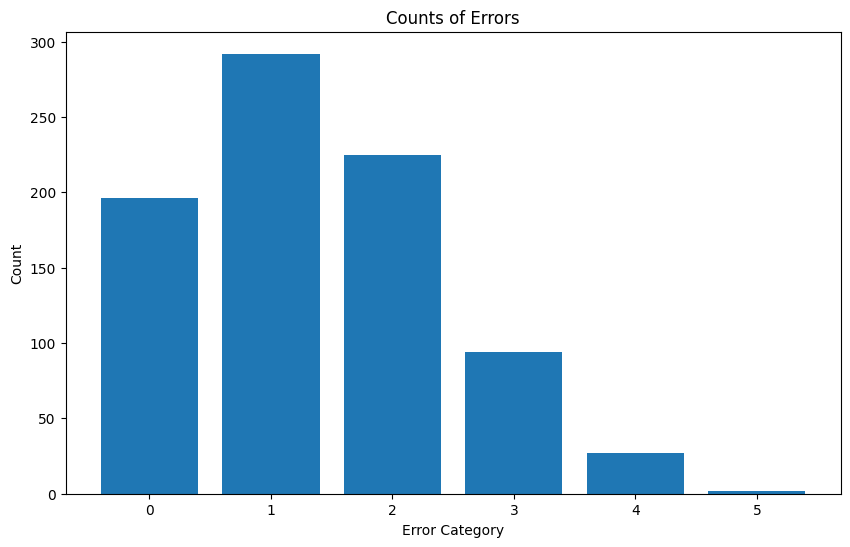

In [ ]:
counts = asset_metadata['errors'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Error Category")
plt.ylabel("Count")
plt.title("Counts of Errors")
plt.show()

We can see that minority of all web searches fail for a particular asset. Maybe we can try to pass this information to the llm to make it generate a description of the asset, since most of the time, at least one link can be accessed.

However, the usefulness of the information inside is hard to evaluate and look through

In [ ]:
# find assets with 5 errors
five_errors = asset_metadata[asset_metadata['errors'] == 5]
five_errors.head()

,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp,tavily_search_results,content,errors
31,FR0011993179,France,UNK_110,Bond,Government,ALXP,Sovereign,NaN,2018-01-01,"{'query': 'FR0011993179 France information', '...","[{'content': '', 'url': 'https://cbonds.com/bo...",5
77,LU0212175227,BNP Paribas Funds EURO Short Term Bond Opportu...,UNK_1040,MTF,Bond,CCLX,NaN,NaN,2018-01-02,{'query': 'LU0212175227 BNP Paribas Funds EURO...,"[{'content': 'error', 'url': 'https://hozampla...",5


In [ ]:
five_errors.loc[77, 'content']

[{'content': 'error',
  'url': 'https://hozamplaza.hu/fajlok/alap-dokumentumok/LU0212175227KIID.pdf'},
 {'content': 'error',
  'url': 'https://www.erstemarket.hu/befektetesi_alapok/dokumentumok/LU0212175227_p-75.pdf'},
 {'content': '',
  'url': 'https://www.scopeexplorer.com/en/details/bnp-paribas-sustainable-euro-bd-classic-cap/30555'},
 {'content': '',
  'url': 'https://docfinder.bnpparibas-am.com/api/files/5fa10697-712e-437b-bb49-1dc8d14e2c03/512'},
 {'content': '',
  'url': 'https://docfinder.bnpparibas-am.com/api/files/21ff9e5c-6d0c-4d13-9f12-5e14df3c8ab0/512'}]

In [ ]:
response = call_llm(
    isin='LU0212175227',
    name='BNP Paribas Funds EURO Short Term Bond Opportunities Classic Capitalisation',
    short_name='UNK_1040',
    asset_category='MTF',
    parsed_content=five_errors.loc[77, 'content']
)

In [ ]:
response[-1].parsed.model_dump()

{'ticker': 'unknown',
 'description': '# Objective\nThe BNP Paribas Funds EURO Short Term Bond Opportunities Classic Capitalisation fund aims to provide investors with a return by investing in a diversified portfolio of short-term euro-denominated debt securities. The primary objective is to achieve capital appreciation over the medium term while managing risk. The fund seeks to benefit from opportunities in the European short-term bond market, focusing on investment-grade instruments. It may also invest in high-yield bonds, but with a limited allocation to manage volatility. The strategy involves active management to select securities that offer attractive risk-adjusted returns.\n# Investment Style\nThe fund employs an active management style, meaning the portfolio managers make discretionary decisions about which securities to buy, sell, and hold. The investment universe primarily consists of euro-denominated bonds with short maturities, typically ranging from 0 to 3 years. This focu

In [ ]:
response[-1].usage_metadata.total_token_count

1708

In [ ]:
# can work on improving this through structured outputs maybe
print(response[-1].parts[0].text)

{
  "ticker": "unknown",
  "description": "# Objective\nThe BNP Paribas Funds EURO Short Term Bond Opportunities Classic Capitalisation fund aims to provide investors with a return by investing in a diversified portfolio of short-term euro-denominated debt securities. The primary objective is to achieve capital appreciation over the medium term while managing risk. The fund seeks to benefit from opportunities in the European short-term bond market, focusing on investment-grade instruments. It may also invest in high-yield bonds, but with a limited allocation to manage volatility. The strategy involves active management to select securities that offer attractive risk-adjusted returns.\n# Investment Style\nThe fund employs an active management style, meaning the portfolio managers make discretionary decisions about which securities to buy, sell, and hold. The investment universe primarily consists of euro-denominated bonds with short maturities, typically ranging from 0 to 3 years. This 

## Set up loop to call model to generate descriptions

In [ ]:
# NOTE: do not run this cell again
error_lst = [] # list of indices with errors

for idx in range(0, len(asset_metadata)):
    row = asset_metadata.iloc[idx]
    isin: str = row['ISIN']
    name: str = row['assetName']
    short_name: str = row['assetShortName']
    asset_category: str = row['assetCategory']
    parsed_content: list = row['content']
    # try 3 times per asset
    success = False
    for attempt in range(3):
        try:
            # call gemini to get response
            response: list = call_llm(
                isin=isin,
                name=name,
                short_name=short_name,
                asset_category=asset_category,
                parsed_content=parsed_content,
            )

            # if somehow gemini did not output anything
            if response is None or len(response) == 0 or response[-1].parsed is None:
                error_lst.append(idx)
                break

            # extract last element from list because it is the response
            output: dict = response[-1].parsed.model_dump()

            with open(f'../../data/gemini_results/{idx}.json', 'w') as f:
                json.dump(output, f, indent=2)
            # successfully wrote the file
            success = True

        except Exception as e:
            # if we hit rate limit, sleep for 60 seconds
            print(e)
            time.sleep(60)

        if success:
            break
    if not success:
        error_lst.append(idx)

    if (idx + 1) % 10 == 0:
        print(f'Completed {idx + 1} rows so far.')

Completed 40 rows so far.
Completed 50 rows so far.
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '58s'}]}}
Completed 60 rows so far.
Completed 70 rows so far.
Completed 80 rows so far.
429 RESOU

In [ ]:
set(error_lst) # row indices that have an error generating a response, we can investigate them later

{30, 35, 36, 60, 441, 446, 545, 580, 627, 628, 633, 637, 640, 654}

These are rows where the model was going to output redacted information

In [ ]:
error_lst = {36, 446, 545, 580, 628, 633, 637, 30, 60, 441, 627, 640, 654, 35} # all are fixed either by re running the api calls, or prompting ChatGPT instead

In [ ]:
# retry for the indices that couldnt work the first time around

retry_lst = []

for idx in error_lst:
    try:
        response = call_llm(
            isin=asset_metadata.loc[idx, 'ISIN'],
            name=asset_metadata.loc[idx, 'assetName'],
            short_name=asset_metadata.loc[idx, 'assetShortName'],
            asset_category=asset_metadata.loc[idx, 'assetCategory'],
            parsed_content=asset_metadata.loc[idx, 'content']
        )

        retry_lst.append((idx, response[-1].parsed.model_dump()))
    except Exception as e:
        print(f'{e}, failed to try for index {idx}')

'NoneType' object has no attribute 'model_dump', failed to try for index 545
'NoneType' object has no attribute 'model_dump', failed to try for index 36
'NoneType' object has no attribute 'model_dump', failed to try for index 580
'NoneType' object has no attribute 'model_dump', failed to try for index 628
'NoneType' object has no attribute 'model_dump', failed to try for index 633
'NoneType' object has no attribute 'model_dump', failed to try for index 637
'NoneType' object has no attribute 'model_dump', failed to try for index 446


In [ ]:
for idx, output in retry_lst:
    file_path = f'../../data/gemini_results/{idx}.json'
    if os.path.exists(file_path):
        raise ValueError('File already exists')
    else:
        with open(file_path, 'w') as f:
            json.dump(output, f, indent=2)

In [ ]:
retry_lst

[]

In [ ]:
response[-1].parsed.model_dump()

{'ticker': 'CSH',
 'description': "# Objective\nThe Lyxor Euro Overnight Return UCITS ETF Acc aims to track the performance of the benchmark index Total Return Eonia Investable Index (calculated to t+3 sett). This index is derived from the EONIA (Euro Overnight Index Average) reference rate, which represents the overnight unsecured lending rate in the Eurozone interbank market. The fund seeks to provide investors with exposure to this key monetary rate.\n\n# Investment Style\nThis ETF is an exchange-traded fund (ETF) that employs an indexing investment approach. It is designed to offer transparent, liquid, and low-cost exposure to its underlying benchmark index. The fund is categorized under Money Market - Other by Morningstar and invests 100% in 'Other' assets, indicating its focus on short-term money market instruments or cash equivalents that closely follow the EONIA rate. It is an accumulating fund, meaning that any income generated is reinvested back into the fund rather than bein

In [ ]:
# manually fill in the asset data
asset_metadata.loc[637]

ISIN                                                          LU1514167722
assetName                Schroder International Selection Fund Global C...
assetShortName                                                     UNK_728
assetCategory                                                          MTF
assetSubCategory                                                      Bond
marketID                                                              XLUX
sector                                                                 NaN
industry                                                               NaN
timestamp                                                       2018-07-18
tavily_search_results    {'query': 'LU1514167722 Schroder International...
content                  [{'content': 'ENSchroder International Selecti...
errors                                                                   0
Name: 637, dtype: object

In [ ]:
asset_metadata.loc[637, 'assetName']

'Schroder International Selection Fund Global Credit Income A Accumulation EUR Hedged'

In [ ]:
asset_metadata.loc[637, 'content']

[{'content': "ENSchroder International Selection Fund Global Credit Income A Accumulation EUR HedgedDividend yield over time?Exclusive feature for our aristocrats.Your total return till today, given you'd invested €10,000 on 3 September 2024.\xa0Starting Amount€10,000.00Price Gain-Price Growth (CAGR)-Dividends-Total Gain-End Balance-Total Return-Total Return (CAGR)-Ex-DatePay DateAmountChangeNo dividends history available for Schroder International Selection Fund Global Credit Income A Accumulation EUR Hedged.Ex-DatePay DateAmountChangeDateRatioNo splits history available for Schroder International Selection Fund Global Credit Income A Accumulation EUR Hedged.Schroder International Selection Fund Global Credit Income A Accumulation EUR Hedged currently pays no dividends.United StatesSwitzerlandUnited KingdomNetherlandsSingaporeIrelandInformation TechnologyFinancialsConsumer DiscretionaryHealth CareCommunication ServicesIndustrialsConsumer StaplesEnergyUtilitiesReal EstateMaterials© 202

### Pick a few examples and evaluate their correctness

In [ ]:
gemini_responses = []
# ensure sequential order of loading data
for i in range(836): # 836 assets so 836 indices
    with open(f'../../data/gemini_results/{i}.json', 'r') as f:
        gemini_response = json.load(f)
        gemini_responses.append(gemini_response)

In [ ]:
gemini_responses[0]

{'ticker': 'DELPOIB',
 'description': '# Objective\nThe "Delos PET-OTE Balanced Fund" is classified as a balanced fund, suggesting an investment objective that seeks to achieve a balance between capital growth and income generation. This is typically pursued through a diversified investment strategy.\n\n# Investment Style\nThe fund\'s investment style is characterized as "Mixed" and "Balanced". This indicates a portfolio allocation that typically includes a combination of equities and fixed-income securities. The specific allocation may vary, but the aim is to provide diversification and a blend of growth potential from equities and stability or income from bonds. The fund\'s approach likely involves selecting assets that contribute to both capital appreciation and income generation, aligning with its balanced objective.'}

In [ ]:
asset_metadata['description'] = [gemini_response['description'] for gemini_response in gemini_responses]
asset_metadata['ticker'] = [gemini_response['ticker'] for gemini_response in gemini_responses]

In [ ]:
sample = asset_metadata.sample(10, random_state=42)

In [ ]:
sample.head()

,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp,tavily_search_results,content,errors,description,ticker
611,LU0823417810,BNP Paribas Funds Sustainable Global Low Vol E...,UNK_689,MTF,Equity,XLUX,NaN,NaN,2018-01-02,{'query': 'LU0823417810 BNP Paribas Funds Sust...,"[{'content': '', 'url': 'https://cbonds.com/et...",1,# Objective\nThe sub-fund seeks to increase th...,unknown
823,GRC419120AD7,GREEK ORGANISATION OF FOOTBALL PROGNOSTICS S.A.,ΟΠΑΠΟ2,Bond,Corporate,EBB,Corporate,Hotels and Lodging,2020-10-19,{'query': 'GRC419120AD7 GREEK ORGANISATION OF ...,[{'content': 'Greek Organisation of Football P...,0,The financial asset is a bond issued by the Gr...,OPAPB2
290,GRS341003002,EUROMEDICA S.A. (CR),ΕΥΡΟΜ,Stock,NaN,XATH,NaN,NaN,2018-01-02,{'query': 'GRS341003002 EUROMEDICA S.A. (CR) i...,"[{'content': '', 'url': 'https://www.athexgrou...",1,EUROMEDICA S.A. is a publicly traded company l...,EUROM
801,FR0013232105,Agence Francaise de Developpement,UNK_114,Bond,Corporate,XPAR,Corporate,Banks,2019-01-11,{'query': 'FR0013232105 Agence Francaise de De...,"[{'content': '', 'url': 'https://cbonds.fr/com...",1,# Bond Objective\nWhile the specific objective...,unknown
168,GRC5091217D9,PRODEA R.E.I.C. S.A.,ΠΡΟΝΤΕΑΟ1,Bond,Corporate,XATH,Corporate,Real Estate Investment and Services,2021-07-21,{'query': 'GRC5091217D9 PRODEA R.E.I.C. S.A. i...,"[{'content': '', 'url': 'https://cbonds.com/bo...",2,# Bond Objective\nInformation regarding the sp...,PRODEAB1


In [ ]:
# find description of LU0823417810
print(sample.loc[611, 'description'])

# Objective
The sub-fund seeks to increase the value of its assets over the medium term. It achieves this by investing in worldwide equities, primarily from socially responsible companies. The selection process is designed to reduce risk by focusing on low volatility securities.
# Investment Style
The fund invests in large-capitalization equities and employs a blend investment style. It is categorized as Global Large-Cap Blend Equity. The investment strategy specifically targets low volatility securities to manage risk. The fund's income is accumulated, meaning any earnings are reinvested back into the fund rather than distributed to investors. The fund is domiciled in Luxembourg and was launched on May 17, 2013. As of July 31, 2025, the fund size was 456.90 million GBP, with the share class size at 210.34 million GBP. The ongoing charge is 1.97%.


In [ ]:
print(preprocess_search_content(sample.loc[611, 'content']))

### Search result 1
url: https://cbonds.com/etf/61348/

### Search result 2
url: https://www.bnpparibas-am.lu/private-investor-retail-investor/fundsheet/equity/bnp-paribas-sustainable-global-low-vol-equity-classic-c-lu0823417810
 (EN)Welcome to BNP Paribas Asset ManagementWhere are you located?Where are you located?Your language selection might change which type of investor choice you can access.What type of investor are you?-XSEPX--XSEPX--XSEPX-Where are you located?Your language selection might change which type of investor choice you can access.What type of investor are you?Website terms and conditionsBy clicking accept, you confirm you have read and understood the terms and conditions.Client portalFundsAboutAbout us overviewFunds 0Articles 0Content 0Fund documentsView fund document results© 2025 BNP Paribas Asset Management. All rights reserved
### Search result 3
url: https://markets.ft.com/data/funds/tearsheet/summary?s=lu0823417810:eur
BNP Paribas Funds Sustainable Global Low Vo

LLM output seems correct given the web search content

In [ ]:
# find description of GRC419120AD7
print(sample.loc[823, 'description'])

The financial asset is a bond issued by the Greek Organisation of Football Prognostics SA (OPAP). OPAP is a company based in Greece that is engaged in the operation of numerical lottery games and sports betting. Its portfolio of games includes popular offerings such as JOKER, LOTTO, PROTO, EXTRA 5, SUPER 3, KINO, PROPO, PROPOGOAL, and STIHIMA. The company conducts its business operations across Greece and Cyprus, utilizing both online platforms and a network of land-based points of sale. The specific bond identified by ISIN GRC419120AD7 is traded on the Athens Stock Exchange within the Fixed Income Securities market. While the web search results provide details about the issuer's business activities and financial performance as a company, specific details regarding the bond's objective, maturity date, and current yield are not explicitly available in the provided search snippets. The bond is listed under the symbol OPAPB2 and is part of the securities market, trading in EUR.


In [ ]:
print(preprocess_search_content(sample.loc[823, 'content']))

### Search result 1
url: https://www.cnbc.com/quotes/OPAP-GR
Greek Organisation of Football Prognostics SA OPAP-GR:Athens Stock ExchangeLatest On Greek Organisation of Football Prognostics SA Key StatsLatest On Greek Organisation of Football Prognostics SA KEY STATSRATIOS/PROFITABILITYEVENTSContent From Our AffiliatesThere is no recent news for this security.ProfileGot a confidential news tip? We want to hear from you.Sign up for free newsletters and get more CNBC delivered to your inboxGet this delivered to your inbox, and more info about our products and services.© 2025 CNBC LLC. All Rights Reserved. A Division of NBCUniversal
      Data is a real-time snapshot *Data is delayed at least 15 minutes.
      Global Business and Financial News, Stock Quotes, and Market Data
      and Analysis.
    Data also provided by
### Search result 2
url: https://www.marketscreener.com/quote/bond/ORGANIZATION-OF-FOOTBALL--114410765/graphics-comparison/
Log In
                                         

Output seems reasonable given the input content and links

In [ ]:
# find description of GRS341003002
print(sample.loc[290, 'description'])

EUROMEDICA S.A. is a publicly traded company listed on the Athens Exchange (ATHEX) with ISIN GRS341003002. The company operates within the healthcare sector, focusing on Healthcare Facilities & Services, including Ambulance & Emergency Services. As of its last reported fiscal period in December 2018, Euromedica S.A. employed approximately 2,633 individuals and generated significant sales within Greece. The company's business involves providing a range of healthcare services, positioning it as a key player in the Greek healthcare market. While specific details regarding its market capitalization category (e.g., large-cap, mid-cap, small-cap) are not explicitly provided in the search results, it is identified as a stock on the ATHEX Main Market. The company's management includes individuals such as Nikolaos T. Liakounakos as Chairman and Giannis-Nikos Nikitas as Director of Finance/CFO.


In [ ]:
print(preprocess_search_content(sample.loc[290, 'content']))

### Search result 1
url: https://www.athexgroup.gr/documents/10180/83937/_content_gr_announcements_Files_20120131+%CE%95%CE%9B%CE%91_EN+_100B.pdf/87bdf4e1-9e9f-4c3c-998e-a633dd0efe31

### Search result 2
url: https://www.bloomberg.com/profile/company/DNX:GR
BloombergConnecting decision makers to a dynamic network of information, people and ideas, Bloomberg quickly and accurately delivers business and financial information, news and insight around the worldFor CustomersSupportAmericas+1 212 318 2000EMEA+44 20 7330 7500Asia Pacific+65 6212 1000CompanyCommunicationsFollowProductsIndustry ProductsMediaMedia ServicesCompanyCommunicationsFollowProductsIndustry ProductsMediaMedia ServicesBloombergConnecting decision makers to a dynamic network of information, people and ideas, Bloomberg quickly and accurately delivers business and financial information, news and insight around the worldFor CustomersSupportAmericas+1 212 318 2000EMEA+44 20 7330 7500Asia Pacific+65 6212 1000Euromedica SA
### Se

Description seems to be mostly generated from LLM knowledge. It takes details about the CEO/etc. from some of the results correctly though, but perhaps due to the shortened inputs, we did not give it information that it could directly extract. Overall, description seems to be correct, as it talks about healthcare services

In [ ]:
# find description of GRC419120AD7
print(sample.loc[801, 'description'])

# Bond Objective
While the specific objective of this particular bond is not detailed in the provided search results, the Agence Française de Développement (AFD) is a public development-finance institution. Its overarching mission is to alleviate poverty and foster sustainable development in developing countries and French Overseas Provinces. Bonds issued by AFD are typically used to finance projects aligned with these goals, contributing to economic growth, improved living conditions, and environmental protection.

# Underlying Company Information
The bond is issued by the Agence Française de Développement (AFD). AFD is a public national industrial and commercial establishment, executing France's development aid policies. It operates across four continents with a network of offices, supporting projects that aim to improve living conditions, promote economic growth, and protect the planet.

# Underlying Company Business
The AFD's core business involves providing financing and assistanc

In [ ]:
print(preprocess_search_content(sample.loc[801, 'content']))

### Search result 1
url: https://cbonds.fr/company/32051/

### Search result 2
url: https://slocat.net/our-partners-old-2/afd/
Our Work & ImpactSpotlightsTransport, Climate and Sustainability Global Status Report– 4th EditionNDCs Library#FossilFreeTransportNews & ResourcesLatest News
COP30: A Turning Point for Climate Action in Transport

Strengthening Freight Transport Resilience: A Climate Imperative for a +2°C World

SLOCAT Welcomes Bridges to Prosperity as New Partner

Seizing the Decade: Why Sustainable Transport Matters

Seizing the Decade: Reinforcing Sustainable Transport’s Central Role in Thriving Communities and Economies

Climate Finance and Economic Mechanisms: Two Essential Yet Mismatched Pieces of the Sustainable Transport Puzzle
Our Work & ImpactSpotlightsTransport, Climate and Sustainability Global Status Report– 4th EditionNDCs Library#FossilFreeTransportNews & ResourcesLatest News
COP30: A Turning Point for Climate Action in Transport

Strengthening Freight Transport 

Output generally seems correct

In [ ]:
# find description of GRC5091217D9
print(sample.loc[168, 'description'])

# Bond Objective
Information regarding the specific objective of the bond GRC5091217D9 was not explicitly found in the provided search results. Typically, bonds are issued to raise capital for a company's operations, expansion, or to refinance existing debt.

# Underlying Company Information
The bond is associated with Prodea Real Estate Investment Company SA, a publicly traded company based in Greece. The company is primarily engaged in the real estate sector.

# Underlying Company Business
Prodea Real Estate Investment Company SA focuses on acquiring and managing a diverse portfolio of real estate assets. Its activities span commercial properties, including offices and retail spaces, with strategic expansion into logistics, hospitality, and residential sectors. The company holds over three hundred properties, predominantly in urban areas across Greece and Cyprus, with additional selective investments in markets such as Italy, Romania, and Bulgaria.

# Maturity Date
The maturity date 

In [ ]:
# find description of GRC5091217D9
print(preprocess_search_content(sample.loc[168, 'content']))

### Search result 1
url: https://cbonds.com/bonds/1081123/

### Search result 2
url: https://www.barrons.com/market-data/stocks/prodea?countrycode=gr
Please enable JS and disable any ad blocker
### Search result 3
url: https://www.investing.com/equities/mig-real-estate-reic

### Search result 4
url: https://www.reuters.com/markets/companies/PRODr.AT
ATH Markets ATHProdea Real Estate Investment Company SAKey Statistics2025 (millions EUR)About Prodea Real Estate Investment Company SA (PRODr.AT)Company InformationProdea Real Estate Investment Company SA is a Greece-based company primarily engaged in real estate. The Company is active in acquiring and managing real estate assets, including commercial properties such as offices and retail spaces, while also expanding into logistics, hospitality, and residential sectors. The Company's diverse portfolio comprises of over three hundred properties located mainly in urban areas both in Greece and Cyprus. The portfolio of the Company also include

Output from model is reasonable

In [ ]:
asset_metadata[asset_metadata['errors'] == 5]

,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp,tavily_search_results,content,errors
31,FR0011993179,France,UNK_110,Bond,Government,ALXP,Sovereign,NaN,2018-01-01,"{'query': 'FR0011993179 France information', '...","[{'content': '', 'url': 'https://cbonds.com/bo...",5
77,LU0212175227,BNP Paribas Funds EURO Short Term Bond Opportu...,UNK_1040,MTF,Bond,CCLX,NaN,NaN,2018-01-02,{'query': 'LU0212175227 BNP Paribas Funds EURO...,"[{'content': 'error', 'url': 'https://hozampla...",5


In [ ]:
gemini_responses[31]

{'ticker': 'OAT',
 'description': '# Bond Objective\nThis bond, identified by ISIN FR0011993179, is an Obligation Assimilable du Trésor (OAT), a type of French government bond. Its primary objective is to provide financing for the French state\'s expenditures and debt management. These bonds are issued by the French Treasury.\n\n# Underlying Company Information\nThe issuer of this bond is the Republic of France.\n\n# Underlying Company Business\nThe Republic of France, as a sovereign nation, engages in a wide range of economic activities and provides public services. Its "business" encompasses fiscal policy, economic regulation, social welfare, defense, and international relations, all funded through taxation and debt issuance.\n\n# Maturity Date\nThe maturity date for this specific OAT is November 25, 2024.\n\n# Yield\nAs of November 16, 2016, the yield for this bond was reported as 0.033%. Yields on government bonds are subject to market conditions and can fluctuate.'}

Output seems reasonable

In [ ]:
gemini_responses[77]

{'ticker': 'unknown',
 'description': "# Objective\nThe investment objective of the BNP Paribas Funds EURO Short Term Bond Opportunities fund is to achieve the best possible return in EUR for the assets invested, taking into account the risks associated with the investment. The fund primarily invests in bonds and money market instruments denominated in EUR. It may also invest in bonds and money market instruments denominated in other currencies, up to a maximum of 10% of its net assets. The fund's strategy focuses on short-term debt securities, aiming to provide capital preservation and liquidity while seeking attractive yields in the Eurozone.\n# Investment Style\nThe fund employs an active management style. It invests in a diversified portfolio of Euro-denominated bonds and money market instruments, including government bonds, corporate bonds, and other debt securities. The investment horizon is typically short-term, focusing on securities with remaining maturities that align with th

Reasonable output

## Export as a csv file

In [ ]:
tickers = [fund['ticker'] for fund in gemini_responses]
descriptions = [fund['description'] for fund in gemini_responses]

In [ ]:
asset_metadata['ticker'] = tickers
asset_metadata['description'] = descriptions

In [ ]:
asset_metadata.to_csv(OUT_DIR / "asset_information_final.csv", index=False)

In [ ]:
asset_metadata.head()

,ISIN,assetName,assetShortName,assetCategory,assetSubCategory,marketID,sector,industry,timestamp,tavily_search_results,content,errors,ticker,description
0,GRF000011004,DHLOS PET OTE,DELPOIB,MTF,Balanced,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000011004 DHLOS PET OTE informat...,"[{'content': 'error', 'url': 'https://www.nbga...",3,DELPOIB,"# Objective\nThe ""Delos PET-OTE Balanced Fund""..."
1,GRF000014008,DELOS FIXED INCOME PLUS - BOND FUND,DELDBDF,MTF,Structured,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000014008 DELOS FIXED INCOME PLU...,"[{'content': 'error', 'url': 'https://www.nbga...",3,DELDBDF,# Objective\nThe fund aims to provide investor...
2,GRF000022001,ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ & ΜΕΣΟΠΡΟΘΕΣΜΩΝ ΕΠΕΝΔΥΣΕΩ...,DELPIMM,MTF,Money Market,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000022001 ΔΗΛΟΣ ΒΡΑΧΥΠΡΟΘΕΣΜΩΝ &...,[{'content': 'ΕΘΝΙΚΗ ΤΡΑΠΕΖΑ Μη προσβάσιμη ι...,0,DELPIMM,# Objective\nThe fund's primary objective is t...
3,GRF000023009,DHLOS EISODHMATOS OMOLOGIAKO ESOTERIKOY,DELFXIB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000023009 DHLOS EISODHMATOS OMOL...,[{'content': 'ΕΘΝΙΚΗ ΤΡΑΠΕΖΑ Μη προσβάσιμη ι...,0,unknown,# Objective\nThe investment objective of the M...
4,GRF000024007,DHLOS EUROBOND,DELEURB,MTF,Bond,AEDAK,NaN,NaN,2018-01-02,{'query': 'GRF000024007 DHLOS EUROBOND informa...,"[{'content': 'error', 'url': 'https://www.nbga...",2,DELEURB,# Objective\nThe Delos Eurobond fund aims to a...


In [ ]:
# we can drop tavily_search_results, content, errors in the future, just keeping first in case